# All good with Seurasaaris trees?

Let's think back to September 2021, nice and warm it was. But was it too warm for Seurasaaris trees?

We get some Sentinel-2 data of the time to check how the trees were doing at the time.
Luckily we find a file on Allas that includes 4 band (rgbnir) Sentinel-2 data of 26.09.2021 that we had prepared for some other project.
-> `S2B_RGBNIR_20210926_Helsinki.tif`
Let's get it and check it out...

In [16]:
# first we need to import rasterio library (https://rasterio.readthedocs.io/en/latest/)
import rasterio
print(rasterio.__version__)

1.2.10


In [17]:
# then we can read our file directly from Allas utilizing 'vsicurl' and the link to our file on Allas public bucket: https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki_Allas.tif
raster = rasterio.open('/vsicurl/https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki_Allas.tif')


In [18]:
# Now we can check that this worked by having a look at the metadata

raster.meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 2466,
 'height': 1832,
 'count': 4,
 'crs': CRS.from_epsg(32635),
 'transform': Affine(10.0, 0.0, 379820.0,
        0.0, -10.0, 6685870.0)}

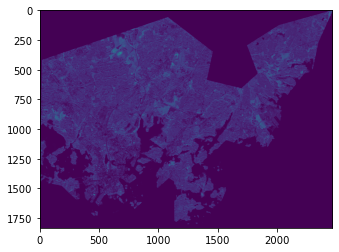

<AxesSubplot:>

In [19]:
# this did not tell too much, better to actually have a look what the data looks like
# the near infrared band should have something to do with vegetation

from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

nir = raster.read(4)

show(nir)

In [20]:
# ok, there is Helsinki, but maybe only the nir band is not enough to look at...
# let's plot a 'common false color image' instead
# we need arrays of nir , green, red to be interpreted as rgb

# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)


print(red.max())
print(green.max())


16208
16880


In [21]:
%run stretch_histogram.py 

<Figure size 432x288 with 0 Axes>

In [22]:
nirs = stretch(nir)
reds = stretch(red)
greens = stretch(green)

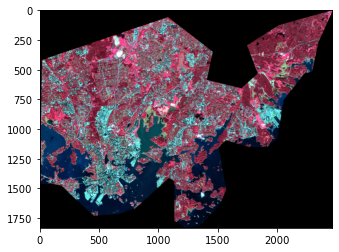

In [23]:
# Create RGB natural color composite stack
rgb = np.dstack((nirs, reds, greens))

# Let's see how our color composite looks like
plt.imshow(rgb)

In [24]:
# Ah yes, vegetation in red, all good
# However, cannot really see what is going on on Seurasaari
# Since we are not interested in the rest of Helsinki, let's clip out Seurasaari


In [25]:
import osmnx as ox

# Keywords for Seurasaari in such format that they can be found from OSM
seurasaari_q = "Seurasaari, Helsinki, Finland"


# Retrieve the geometries of those areas using osmnx
seurasaari = ox.geocode_to_gdf(seurasaari_q)

seurasaari.crs


/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# put in same crs
seurasaari = seurasaari.to_crs(crs=raster.crs)

seurasaari.crs


<Derived Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
%run get_json_feature.py

<Figure size 432x288 with 0 Axes>

In [28]:
coords = getFeatures(seurasaari)


In [29]:
from rasterio.mask import mask

out_img, out_transform = mask(dataset=raster, shapes=coords, crop=True)

In [146]:
# Copy the metadata
out_meta = raster.meta.copy()
print(out_meta)
# Parse EPSG code
epsg_code = raster.crs.data['init']
print(epsg_code)
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": epsg_code})

out_tif = './data/S2B_RBGNIR_20210926_Seurasaari.tif'
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2466, 'height': 1832, 'count': 4, 'crs': CRS.from_epsg(32635), 'transform': Affine(10.0, 0.0, 379820.0,
       0.0, -10.0, 6685870.0)}
epsg:32635


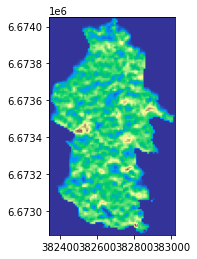

<AxesSubplot:>

In [31]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show((clipped, 4), cmap='terrain')

In [32]:
%run make_false_color_image.py

<Figure size 432x288 with 0 Axes>

In [33]:
rgb = make_false_color_image(clipped)

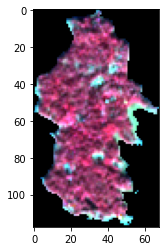

In [34]:
plt.imshow(rgb)

In [35]:
# this looks quite red, so it seems the trees were doing well.
# another way to look at vegetation health is by using the Normalized Difference Vegetation index (xx)

# first we need to read the red and nir bands into arrays
# Read red channel (our channel number 3)
red = clipped.read(3)
# Read NIR channel (our channel number 4)
nir = clipped.read(4)



In [36]:
# then we need to do a few things to the original arrays
# Convert to floats
red = red.astype('f4')
nir = nir.astype('f4')

np.seterr(divide='ignore', invalid='ignore');


In [140]:
# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)

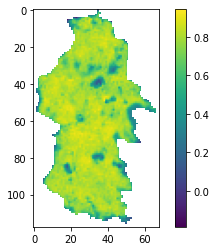

In [38]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi, cmap='viridis')
# Add colorbar to show the index
plt.colorbar()

In [155]:
# lets store this for later



out_meta.update({"count" : 1,
                "dtype" : np.dtype('f4')})

with rasterio.open("seurasaari_ndvi.tif", "w", **out_meta) as dest:
    dest.write_band(1, ndvi.astype(rasterio.float32))



In [39]:
# yes, vegetation is doing really well on Seurasaari!
# hm but not everything is trees on Seurasaari
# Let's check what else there is...



In [47]:
%run get_corine_dict.py

In [41]:
catdict

{1.0: 'Continuous urban fabric',
 2.0: 'Discontinuous urban fabric',
 3.0: 'Commercial units',
 4.0: 'Industrial units',
 5.0: 'Road and rail networks and associated land',
 6.0: 'Port areas',
 7.0: 'Airports',
 8.0: 'Mineral extraction sites',
 9.0: 'Open cast mines',
 10.0: 'Dump sites',
 11.0: 'Construction sites',
 12.0: 'Green urban areas',
 13.0: 'Summer cottages',
 14.0: 'Sport and leisure areas',
 15.0: 'Golf courses',
 16.0: 'Racecourses',
 17.0: 'Non-irrigated arable land',
 18.0: 'Fruit trees and berry plantations',
 19.0: 'Pastures',
 20.0: 'Natural pastures',
 nan: nan,
 21.0: 'Arable land outside farming subsidies',
 22.0: 'Agro-forestry areas',
 23.0: 'Broad-leaved forest on mineral soil',
 24.0: 'Broad-leaved forest on peatland',
 25.0: 'Coniferous forest on mineral soil',
 26.0: 'Coniferous forest on peatland',
 27.0: 'Coniferous forest on rocky soil',
 28.0: 'Mixed forest on mineral soil',
 29.0: 'Mixed forest on peatland',
 30.0: 'Mixed forest on rocky soil',
 31.0: 

In [85]:

from rasterstats import zonal_stats

zstats = zonal_stats(seurasaari,'./data/Clc2018_Seurasaari.tif',categorical=True, category_map=catdict, stats = ['count'])

In [86]:
zstats

[{'Discontinuous urban fabric': 12,
  'Commercial units': 89,
  'Industrial units': 42,
  'Sport and leisure areas': 10,
  'Broad-leaved forest on mineral soil': 20,
  'Coniferous forest on mineral soil': 303,
  'Coniferous forest on rocky soil': 140,
  'Mixed forest on mineral soil': 137,
  'Mixed forest on rocky soil': 38,
  'Transitional woodland/shrub  cc <10%  ': 1,
  'Transitional woodland/shrub, cc 10-30%,on mineral soil': 31,
  'Transitional woodland/shrub, cc 10-30%,  on rocky soil': 51,
  'Bare rock': 3,
  'Inland marshes, terrestrial': 3,
  'Salt marshes, terrestrial': 7,
  'Salt marshes, aquatic': 4,
  'Water bodies': 15,
  'Sea and ocean': 2,
  'count': 908}]

In [87]:
zstat_perc = {}
sum = 0
total = zstats[0]['count']
for key in zstats[0].keys():
    if not key == 'count':
        amount = zstats[0][key]
        perc=  round(amount/total *100)
        zstat_perc[key] = perc
        sum += perc
sum
zstat_perc



{'Discontinuous urban fabric': 1,
 'Commercial units': 10,
 'Industrial units': 5,
 'Sport and leisure areas': 1,
 'Broad-leaved forest on mineral soil': 2,
 'Coniferous forest on mineral soil': 33,
 'Coniferous forest on rocky soil': 15,
 'Mixed forest on mineral soil': 15,
 'Mixed forest on rocky soil': 4,
 'Transitional woodland/shrub  cc <10%  ': 0,
 'Transitional woodland/shrub, cc 10-30%,on mineral soil': 3,
 'Transitional woodland/shrub, cc 10-30%,  on rocky soil': 6,
 'Bare rock': 0,
 'Inland marshes, terrestrial': 0,
 'Salt marshes, terrestrial': 1,
 'Salt marshes, aquatic': 0,
 'Water bodies': 2,
 'Sea and ocean': 0}

In [88]:
# Lets consider only vegetation
vegetation = ['Broad-leaved forest on mineral soil',
 'Coniferous forest on mineral soil',
 'Coniferous forest on rocky soil',
 'Mixed forest on mineral soil',
 'Mixed forest on rocky soil']

# get raster values for these

vegdf = catdf_lim[catdf_lim['Level4Eng'].isin(vegetation)]
vegdf.index


Float64Index([23.0, 25.0, 27.0, 28.0, 30.0], dtype='float64', name='Value')

In [95]:
# use numpy to create mask
corine = rasterio.open('./data/Clc2018_Seurasaari.tif')
corinearray = corine.read(1)
corinearray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [96]:
veglist = vegdf.index.to_list()

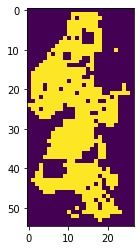

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [115]:


mask = (corinearray == 28) |  (corinearray == int(veglist[1])) | (corinearray == int(veglist[2])) | (corinearray == int(veglist[3])) | (corinearray == int(veglist[4]))
show(mask,1)

type(mask)
mask = mask.astype('uint8')
mask

In [111]:
import fiona
import rasterio
from rasterio import features


#iterate over shapes.
results = (
    {'properties': {'raster_val': v}, 'geometry': s}        
    for i, (s, v) in enumerate(features.shapes(mask, transform = corine.transform)))

with fiona.open(
        'test_shapefile.shp', 'w',
        driver='Shapefile',
        crs=corine.crs,
        schema={'properties': [('raster_val', 'int')],
        'geometry': 'Polygon'}) as dst:
    dst.writerecords(results)

In [157]:
import fiona
import rasterio
import rasterio.mask

with fiona.open("./test_shapefile.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile if feature['properties']['raster_val'] == 1]
    print(shapefile[0])

ndvi = rasterio.open('seurasaari_ndvi.tif')
out_image, out_transform = rasterio.mask.mask(ndvi, shapes, crop=True)
out_meta = ndvi.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("seurasaari_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('raster_val', 0)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(382619.9999999997, 6673960.0), (382639.9999999997, 6673960.0), (382639.9999999997, 6673940.0), (382619.9999999997, 6673940.0), (382619.9999999997, 6673960.0)]]}}


In [174]:
ndvi_veg = rasterio.open("seurasaari_masked.tif").read(1)
print(np.mean(ndvi_veg))
print(np.nanmean(ndvi_veg))

# seems a bit little for what we have seen before?
# lets check

from rasterio.plot import show_hist

fig, axhist = plt.subplots(1, 1)
show_hist(ndvi_veg, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', label = range(1,5), ax = axhist)
axhist.set_xlabel('Reflectance')
#axhist.set_ylabel('Frequency')
axhist.set_title('Histogram')
axhist.set_xlim(left= 0, right= 1)




nan
0.35075343
[0.         0.14000906 0.15403666 ... 0.92913955 0.9434851         nan]
[3146    1    1 ...    1    1    3]


In [171]:
#unlikely that there is any plain 0 values
#ndvi_veg[ndvi_veg == 0] = np.nan
np.nanmean(ndvi_veg)

0.7976835

-> healthy vegetation :)

TODO:

* check that ndvi can go to negative (int not uint?)
* make chapters
* Exercises: 
    * "which one is higher, P or Kallio"?
    * Mosaic DEMs
* in between checks
* outsource some bigger computations
* also provide normalize solution